# 准备工作

## 安装包

In [1]:
%%script true
!pip install git+https://github.com/d2l-ai/d2l-zh@release

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 数据集

kaggle_house（老数据）的id为`1HET6UZ-nH55SwLpWja-4z0QulXxnD8uN`

kaggle（新数据）的id为`1-o0qnKAKzYaXl7XM8_d7j802QSbR8zmv`

两者都存放在googledrive的d2l文件夹中。

In [3]:
%%script true
# new
# !gdown --id 1-o0qnKAKzYaXl7XM8_d7j802QSbR8zmv
!unzip kaggle.zip -d ./data/

# old
!gdown --id 1HET6UZ-nH55SwLpWja-4z0QulXxnD8uN
!unzip kaggle_house.zip -d ./data/

In [4]:
dataset = "new" #@param ["new", "old"]
datasets = {"new": "./data/kaggle",
            "old": "./data/kaggle_house"}

train_data = pd.read_csv(datasets[dataset]+"_train.csv")
test_data = pd.read_csv(datasets[dataset]+"_test.csv")

- 老的训练数据集包括1460个样本，每个样本80个特征和1个标签，而测试数据包含1459个样本，每个样本80个特征。

- 新的训练数据集包括47439个样本，每个样本40个特征和1个标签，而测试数据包含31626个样本，每个样本40个特征。



In [5]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


打印出前四个和最后两个特征，以及前四个样本的标签（房价）：


In [6]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,Address,Sold Price,Summary,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,Culver City,90230,CA


数据第一列是ID，将其从删除：


In [7]:
all_features = pd.concat((train_data.iloc[:, 1:],
                          test_data.iloc[:, 1:]), sort=False)

if dataset == "new":
    remove_columns = ["Address", 'Summary'] #@param
    print(f'remove {remove_columns}')
    all_features = all_features.drop(columns=remove_columns)

remove ['Address', 'Summary']


## 数据预处理
首先**将所有缺失的值替换为相应特征的平均值**，然后标准化数据：

$$x \leftarrow \frac{x - \mu}{\sigma}.$$

使特征具有零均值和单位方差，即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$和$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。


In [8]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，我们可以将缺失值设置为0（平局值）
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来处理离散值（如`MSZoning`等），用独热编码替换它们。为了防止内存不足，这里分段处理：


In [9]:
print(f"before: {all_features.shape}")
all_features = pd.get_dummies(all_features, dummy_na=True)
print(f"after: {all_features.shape}")

before: (79065, 38)
after: (79065, 59520)


你可以看到，此转换会将特征的数量从79个增加到331个。最后，通过`values`属性，我们可以从`pandas`格式中提取NumPy格式，并将其转换为张量表示用于训练。


In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1),
                            dtype=torch.float32)
# train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
#                             dtype=torch.float32)

## 训练

首先，我们训练一个带有损失平方的线性模型。毫不奇怪，我们的线性模型不会让我们在竞赛中获胜，但线性模型提供了一种健全性检查，以查看数据中是否存在有意义的信息。如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。如果一切顺利，线性模型将作为基线模型，让我们直观地知道简单的模型离报告最好的模型有多近，让我们感觉到我们应该从更酷炫的模型中获得多少收益。


In [31]:
in_features = train_features.shape[1]

def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

dropout1 = 0.2 #@param
dropout2 = 0.2 #@param
def get_net():
    net = nn.Sequential(nn.Flatten(),
                        nn.Linear(in_features, 1024), nn.ReLU(), nn.BatchNorm1d(1024), nn.Dropout(dropout1),
                        nn.Linear(1024, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(dropout2),
                        nn.Linear(512, 512), nn.ReLU(),  nn.Dropout(dropout2),
#                         nn.Linear(256, 64), nn.ReLU(), nn.Dropout(dropout2),
                        nn.Linear(512, 1))
    
    net.apply(weight_init)
    return net

对于房价，就像股票价格一样，我们关心的是相对数量，而不是绝对数量。因此，我们更关心相对误差$\frac{y - \hat{y}}{y}$，而不是绝对误差$y - \hat{y}$。例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，我们的预测偏差了10万美元，在那里一栋典型的房子的价值是12.5万美元，那么我们可能做得很糟糕。另一方面，如果我们在加州豪宅区的预测出现了这个数字的偏差，这可能是一个惊人的准确预测（在那里，房价均值超过400万美元）。

解决这个问题的一种方法是用价格预测的对数来衡量差异。事实上，这也是比赛中官方用来评价提交质量的误差指标。即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [12]:
loss1 = nn.MSELoss()
def LogRMSELoss(preds, labels):
    e1 = 1e-7
    preds = torch.clamp(preds, 1, float('inf'))
#     return torch.mean(torch.log(preds/(labels+e1))**2)
    return torch.sqrt(loss1(torch.log(preds), torch.log(labels)))
#     return torch.sqrt(torch.mean(torch.log(preds/(labels+e1))**2))


def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss1(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

与前面的部分不同，我们的训练函数将依赖于Adam优化器（我们将在后面更详细地描述它）。这个优化器的主要吸引力在于，尽管在提供无限资源进行超参数优化方面没有做得更好（有时更差），但人们发现它对初始学习率不那么敏感。


In [ ]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size, device, animator=None):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    
    if animator == None:
        animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                                legend=['train'], xlim=[1, num_epochs])

    for epoch in range(num_epochs):
        epoch_loss = 0
        n = 0
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            
            n += X.shape[0]
            epoch_loss += l.item() * X.shape[0]
        _l = epoch_loss / n
        # _l = log_rmse(net, train_features.to(device), train_labels.to(device))
        train_ls.append(_l)
        animator.add(epoch, _l)
        if test_labels is not None:
            net.eval()
            test_ls.append(log_rmse(net, test_features.to(device), test_labels.to(device)))
            net.train()
    return train_ls, test_ls

In [ ]:
loss = LogRMSELoss
# loss = nn.MSELoss()

0.2406925671112779

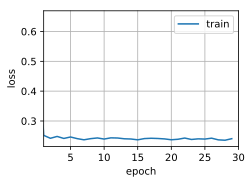

In [32]:
# %%script true
num_epochs = 30
lr, weight_decay = 0.1, 0.00001
batch_size = 128
device = torch.device("cuda:0")
net = get_net().to(device)

train(net, train_features, train_labels, None, None,
      num_epochs, lr, weight_decay, batch_size, device)[0][-1]

## $K$折交叉验证

你可能还记得，我们在讨论模型选择的部分（ :numref:`sec_model_selection` ）中介绍了$K$折交叉验证。这有助于模型选择和超参数调整。我们首先需要一个函数，在$K$折交叉验证过程中返回第$i$折的数据。它选择第$i$个切片作为验证数据，其余部分作为训练数据。注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，我们肯定会做一些更聪明的改变。但是这种改变所增加的复杂性可能会使代码看起来更乱。在这里可以忽略这些改变，因为我们的问题很简单。


In [16]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在$K$折交叉验证中训练$K$次后，返回训练和验证误差的平均值。


In [17]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size, device):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net().to(device)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size, device)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择

在本例中，我们选择了一组未调优的超参数，并将其留给读者来改进模型。找到一个好的选择可能需要时间，这取决于一个人优化了多少变量。有了足够大的数据集和超参数的合适设置，$K$折交叉验证往往对多次测试具有相当的适应性。然而，如果我们尝试了不合理的大量选项，我们可能会发现验证效果不再代表真正的误差。


fold 5, train log rmse 0.232795, valid log rmse 0.207746
5-折验证: 平均训练log rmse: 0.238768, 平均验证log rmse: 0.214783


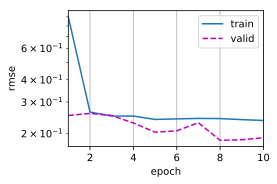

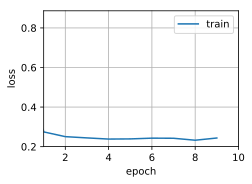

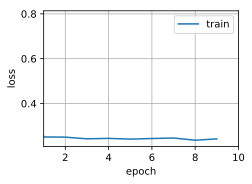

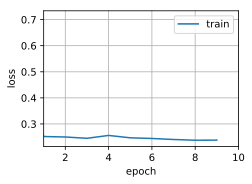

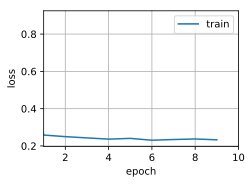

In [34]:
k = 5
num_epochs = 10
lr, weight_decay = 0.1, 0.00001
batch_size = 128

device = torch.device("cuda:0")

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size, device)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

请注意，有时一组超参数的训练误差可能非常低，但$K$折交叉验证的误差要高得多。这表明我们过拟合了。在整个训练过程中，你将希望监控这训练误差和验证误差两个数字。较少的过拟合可能表明现有数据可以支撑一个更强大的模型。较大的过拟合可能意味着我们可以通过正则化技术来获益。

##  提交Kaggle的预测
https://www.kaggle.com/c/california-house-prices/submissions

既然我们知道应该选择什么样的超参数，我们不妨使用所有数据对其进行训练（而不是仅使用交叉验证中使用的$1-1/K$的数据）。然后，我们通过这种方式获得的模型可以应用于测试集。将预测保存在csv文件中可以简化将结果上传到Kaggle的过程。


train log rmse 0.239455


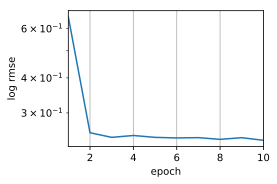

In [35]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    device = torch.device("cuda:0")
    net = get_net().to(device)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size, device)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    
    print(f'train log rmse {float(train_ls[-1]):f}')
    torch.save(net.state_dict(), "net.pt")
    
    device = torch.device("cuda:1")
    net.to(device)
    net.eval()
    preds = net(test_features.to(device))
    preds = preds.detach().cpu()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
num_epochs = 10
# lr, weight_decay = 0.1, 0.00001
# batch_size = 128
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

一种良好的完整性检查是查看测试集上的预测是否与$K$倍交叉验证过程中的预测相似。如果是，那就是时候把它们上传到Kaggle了。下面的代码将生成一个名为`submission.csv`的文件。


In [20]:
net = get_net()
net.load_state_dict(torch.load("net.pt"))
device = torch.device("cuda:1")
net.to(device)
net.eval()
preds = net(test_features.to(device))
preds = preds.detach().cpu()

# 将其重新格式化以导出到Kaggle
test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
submission.to_csv('submission.csv', index=False)